In [1]:
! pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import requests
import plotly.express as px
from bs4 import BeautifulSoup as bs 
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', 2000)
pd.set_option("mode.chained_assignment", None)
sns.set(rc={'figure.figsize':(10, 6)})
sns.set_context("talk")
sns.set_style("whitegrid")



In [3]:
# Load the dataset into a DataFrame
raw_df = pd.read_csv('WorldCupMatches.csv')

In [4]:
# players=pd.read_csv('WorldCupPlayers.csv')

In [5]:
df = raw_df.dropna(how='all', axis=0)

lets start by taking a look at the names of the countries

In [6]:
All_Countrys = list(set((
                        df
                        ['Home Team Name']
                        .values
                        .tolist()
                        +
                        df
                        ['Away Team Name']
                        .values
                        .tolist()
                        ))
                    )

In [7]:
name_mappings = {
    'rn">Bosnia and Herzegovina': 'Bosnia and Herzegovina',
    'rn">Republic of Ireland': 'Republic of Ireland',
    'rn">Serbia and Montenegro': 'Serbia and Montenegro',
    'rn">Trinidad and Tobago': 'Trinidad and Tobago',
    'rn">United Arab Emirates': 'United Arab Emirates',
    "C�te d'Ivoire": "Cote d'Ivoire",
    'German DR': 'Germany',
    'Germany FR': 'Germany'
}

df = df.replace(name_mappings)

#Visualization

Now we can start looking at some cool stuff

lets start by seeing the most common countrys that make it to the world cup

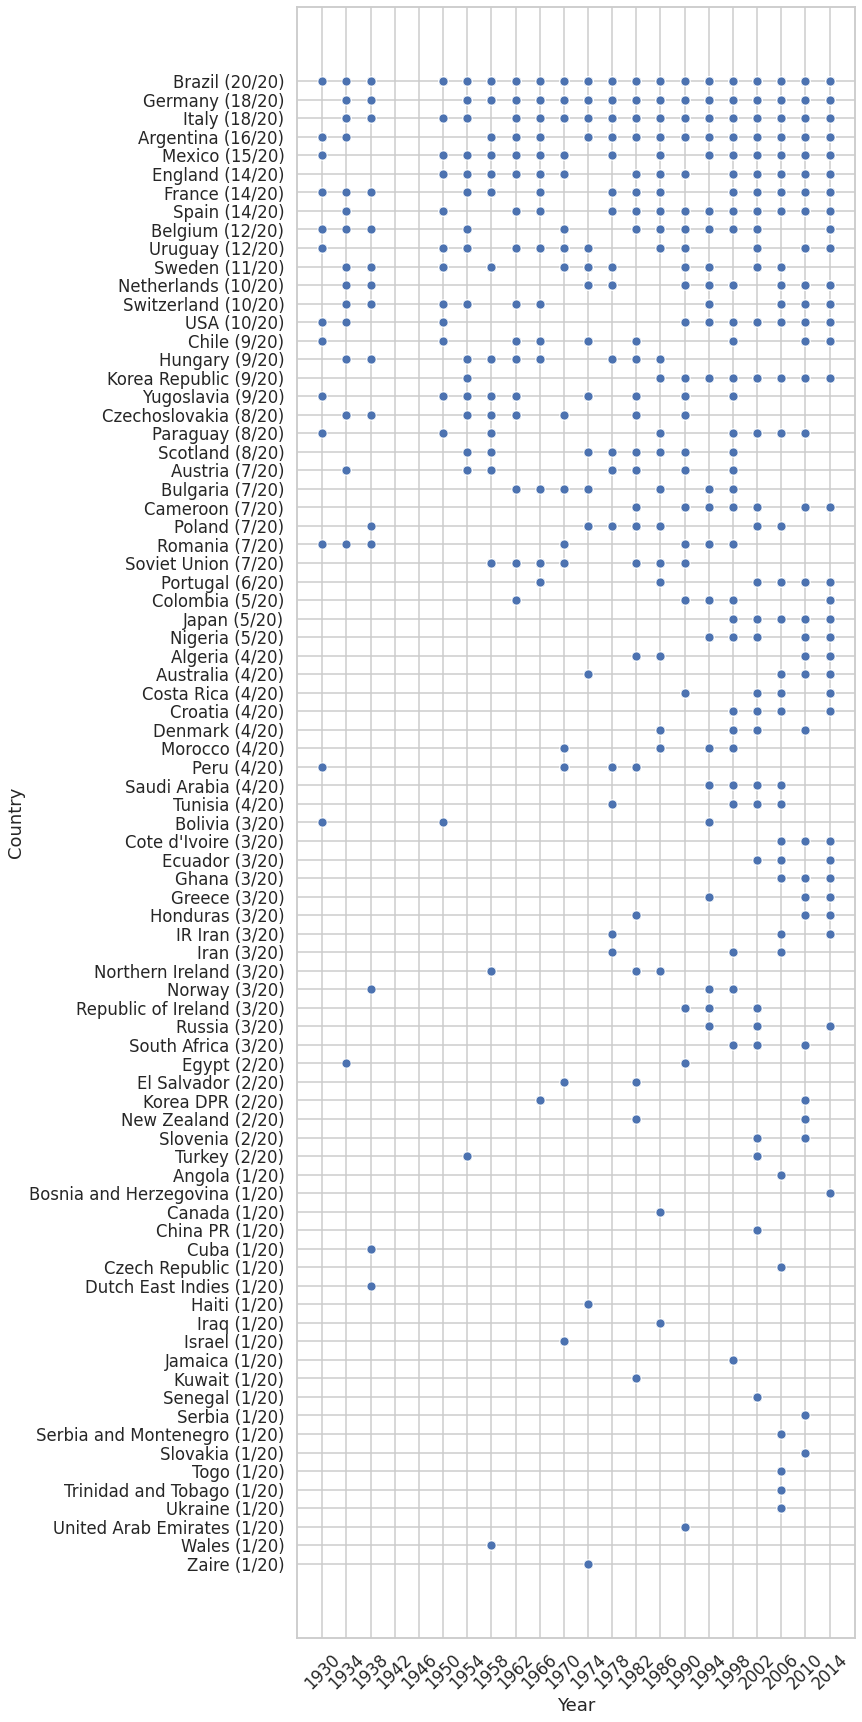

In [8]:

#Melting the df for easier plotting, I only  care about the year and the name at this point
teams_df = (
          df
          [['Year', 'Home Team Name', 'Away Team Name']]
          .melt(id_vars = ['Year'], value_vars = ['Home Team Name', 'Away Team Name'])
          .drop('variable',axis=1)
          .rename(columns = {'value':'Country'})
          .assign(freq = lambda d: d.groupby('Country')['Year'].transform('nunique'))
          .sort_values(by=['freq','Country'],ascending=[False,True])
           )

fig, ax = plt.subplots(figsize=(10, 30))


# scatter plot and making sure the bins of the x axis align with the world cup years
scatter_plot = sns.scatterplot(x = "Year", y = "Country", sizes = (200, 200), data = teams_df)
plt.xticks(np.arange(teams_df.Year.min(), teams_df.Year.max()+1, 4),rotation=45)


#adding the success of qualifying for each country
labels = (
          teams_df
          .drop_duplicates()
          .Country
          .unique()
          .tolist()
          )

newlabels = []
for country_name in labels:
    WorldCup_Participet = len((teams_df
                           [teams_df['Country'] == country_name]
                           .Year
                           .unique()
    ))
    TotalPossible = teams_df['Year'].nunique()
    newlabels.append(f"{country_name} ({WorldCup_Participet}/{TotalPossible})")


scatter_plot.set_yticklabels(newlabels)
plt.show()


Now I think it will be fun to look at the most important aspect, the goals.


Lets take a look at the spread of the avg goal scoring of each country

In [9]:
a = (
    df
    [['Home Team Name','Home Team Goals']]
    .rename(columns={'Home Team Name':'Team Name','Home Team Goals':'Goals_Scored'})
    )
b = (
    df
    [['Away Team Name','Away Team Goals']]
   .rename(columns={'Away Team Name':'Team Name','Away Team Goals':'Goals_Scored'})
    )

df_con = pd.concat([a,b])


df_agg = (
          df_con
          .groupby('Team Name',as_index=False)
          .agg({'Goals_Scored':['sum','count','mean','std']})
          )

df_agg.columns = df_agg.columns.droplevel()
df_agg = (
         df_agg
        .set_axis(['Country','Goals Scored','Games played', 'Mean goals scored','std'], axis=1)
        .fillna(0)
         )


Lets see on the map where are the most good nations at scoring are 

In [10]:
fig = px.choropleth(df_agg,
                    locations = 'Country',
                    locationmode = 'country names',
                    color = 'Goals Scored', 
                   hover_name = 'Country', 
                   title = 'Total Number of Goals Scored by Country',
                   color_continuous_scale = 'Blues')
fig.show()

Plotting some confidence bars

In [11]:
def calc_ci(std,count, z=1.645):
    return z*std/np.sqrt(count)

df_agg['upper_ci'] = df_agg.apply(lambda x: x['Mean goals scored'] + calc_ci( x['std'],x['Games played']) if x['std'] > 0 else 0, axis=1)
df_agg['lower_ci'] = df_agg.apply(lambda x: x['Mean goals scored'] - calc_ci( x['std'],x['Games played']) if x['std'] > 0 else 0 , axis=1)


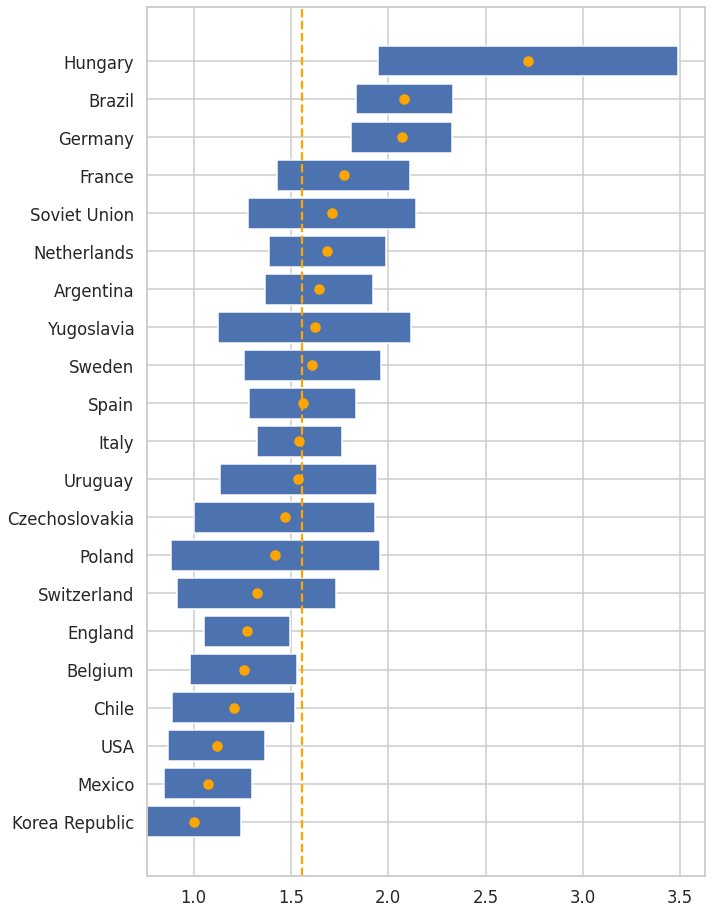

In [12]:
df_agg.sort_values(by='Mean goals scored', inplace=True)

df_agg = df_agg[df_agg['Games played'] >= 30]

fig, ax = plt.subplots(figsize=(10, 16))

plt.barh(y = df_agg['Country'], 
         width = df_agg['upper_ci'] - df_agg['lower_ci'], 
         left = df_agg['lower_ci'])

plt.scatter(df_agg['Mean goals scored'], df_agg['Country'], color='orange', zorder=999)

plt.axvline(df_agg['Mean goals scored'].mean(), linestyle='--', color='orange')

plt.show()

Lets take a look at goals over time and lets add some spice to it by using some external data

In [13]:
url = "https://en.wikipedia.org/wiki/FIFA_World_Cup_hosts"
response = requests.get(url)

soup = bs(response.content, "html.parser")

table = soup.find("table", {"class": "wikitable"})
Location_df= pd.read_html(str(table))[0]

In [14]:
to_plot=(
        df
        .assign(total_goals_in_a_match=df['Home Team Goals']+df['Away Team Goals'])
        .groupby('Year')
        ['total_goals_in_a_match']
        .mean()
        .to_frame()
        .reset_index()
        .merge(Location_df,on='Year')
      )

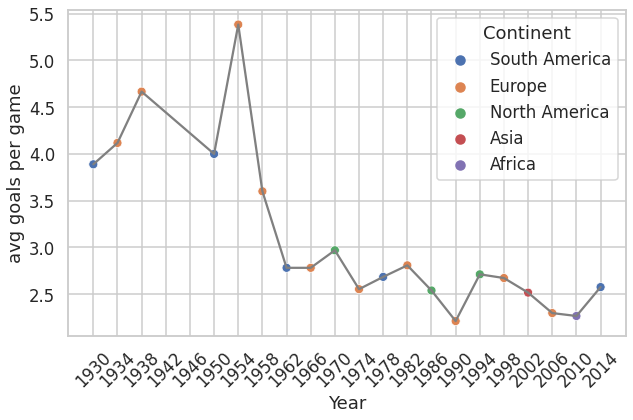

In [15]:
ax = sns.scatterplot(x='Year',y='total_goals_in_a_match',data=to_plot,hue='Continent',marker='o')
plt.plot(to_plot['Year'],to_plot['total_goals_in_a_match'],color='grey')

ax.set_ylabel('avg goals per game')
plt.xticks(np.arange(to_plot.Year.min(), to_plot.Year.max()+1, 4),rotation=45)

plt.show()

lets move on from goals for now,
one thing our data is missing is the results, but we have all the info we need so lets make it work

In [16]:
df['Result'] = np.where(df['Home Team Goals'] > df['Away Team Goals'], df['Home Team Name'],
               np.where(df['Home Team Goals'] < df['Away Team Goals'], df['Away Team Name'], np.NaN))

# Get the number of wins for each team and year
results_df = (
              df
              .groupby(['Year', 'Result'])
              .size()
              .reset_index(name='Wins')
              .dropna()
              .rename(columns={'Result':'Country'})
              .sort_values(['Wins','Year'],ascending=False)
)

In [17]:
List_Of_Countries=(
                    results_df
                   .nlargest(5,columns='Wins')
                   ['Country']
                   .tolist()
)

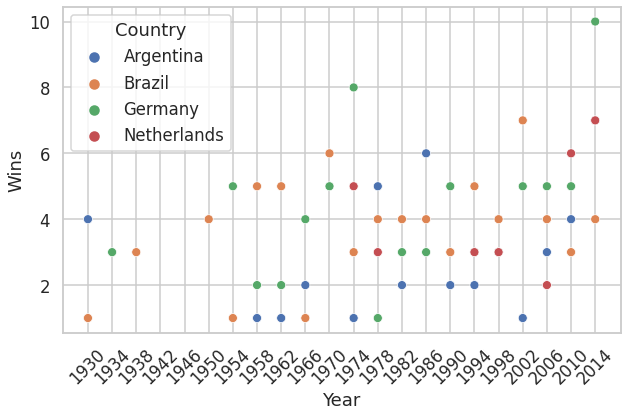

In [18]:
df_to_plot = (
              results_df
              [results_df['Country'].isin(List_Of_Countries)]
              .sort_values(['Year','Country'])
              )

sns.scatterplot(x='Year',y='Wins',hue='Country',data=df_to_plot)
plt.xticks(np.arange(to_plot.Year.min(), to_plot.Year.max()+1, 4),rotation=45)

plt.show()